### Authors
- Gabriel Souza Lima
- Guilherme Mertens
- Kiyoshi Araki
- Lucas Tramonte

### DQN on `highway-fast-v0`

This notebook implements a Deep Q-Network (DQN) to train an agent from scratch in the `highway-fast-v0` environment using a custom configuration.
We will go through the entire pipeline:
1. Environment setup
2. DQN network and replay buffer
3. Training algorithm
4. Evaluation and visualization


### 1. Import dependencies

In [3]:
import gymnasium as gym
import highway_env
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
import time

###  2. Load configuration and prepare environment

In [4]:
with open("config.pkl", "rb") as f:
    config = pickle.load(f)

env = gym.make("highway-fast-v0", render_mode="human")
env.unwrapped.configure(config)
obs_sample, _ = env.reset()
obs_shape = obs_sample.shape
n_actions = env.action_space.n

### 3. Define Hyperparameters

In [6]:
GAMMA = 0.99             # Discount factor
EPS_START = 1.0          # Initial epsilon for exploration
EPS_END = 0.05           # Final epsilon
EPS_DECAY = 500          # Epsilon decay rate
LR = 1e-3                # Learning rate
BATCH_SIZE = 64
TARGET_UPDATE = 5  # updated for more frequent sync       # Target network update interval
MEMORY_SIZE = 100_000
NUM_EPISODES = 150
MAX_STEPS = 400

### 4. Q-Network Architecture

In [7]:
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        flat_dim = int(np.prod(input_shape))
        self.fc = nn.Sequential(
            nn.Linear(flat_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, n_actions)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.fc(x)

### 5. Replay Buffer

In [8]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.array, zip(*batch))
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)

### 6. Epsilon-Greedy Action Selection


In [9]:
def select_action(state, steps_done):
    eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * steps_done / EPS_DECAY)
    if random.random() < eps_threshold:
        return random.randrange(n_actions)
    else:
        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            return policy_net(state_tensor).argmax().item()

We decay epsilon over time:

$$
\epsilon_t = \epsilon_{\text{end}} + (\epsilon_{\text{start}} - \epsilon_{\text{end}}) \cdot e^{-t / \text{decay}}
$$


### 7. Training Loop

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy_net = DQN(obs_shape, n_actions).to(device)
target_net = DQN(obs_shape, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(policy_net.parameters(), lr=1e-4)  # reduced LR for stability
replay_buffer = ReplayBuffer(MEMORY_SIZE)

returns = []
losses = []
steps_done = 0

for episode in range(NUM_EPISODES):
    state, _ = env.reset()
    total_reward = 0
    for t in range(MAX_STEPS):
        action = select_action(state, steps_done)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        replay_buffer.push(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        steps_done += 1

        if len(replay_buffer) > BATCH_SIZE:
            states, actions, rewards, next_states, dones = replay_buffer.sample(BATCH_SIZE)
            states = torch.tensor(states, dtype=torch.float32, device=device)
            actions = torch.tensor(actions, dtype=torch.int64, device=device).unsqueeze(1)
            rewards = torch.tensor(rewards, dtype=torch.float32, device=device).unsqueeze(1)
            next_states = torch.tensor(next_states, dtype=torch.float32, device=device)
            dones = torch.tensor(dones, dtype=torch.float32, device=device).unsqueeze(1)

            q_values = policy_net(states).gather(1, actions)
            with torch.no_grad():
                max_next_q_values = target_net(next_states).max(1)[0].unsqueeze(1)
                target_q_values = rewards + GAMMA * max_next_q_values * (1 - dones)

            loss = nn.MSELoss()(q_values, target_q_values)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(policy_net.parameters(), max_norm=10)  # gradient clipping
            optimizer.step()
            losses.append(loss.item())

        if done:
            break

    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    returns.append(total_reward)
    print(f"Episode {episode+1}/{NUM_EPISODES}, Reward: {total_reward:.2f}")

Episode 1/150, Reward: 13.67
Episode 2/150, Reward: 6.12
Episode 3/150, Reward: 2.20
Episode 4/150, Reward: 2.23
Episode 5/150, Reward: 33.38
Episode 6/150, Reward: 6.92
Episode 7/150, Reward: 17.62
Episode 8/150, Reward: 20.32
Episode 9/150, Reward: 9.97
Episode 10/150, Reward: 3.16
Episode 11/150, Reward: 6.79
Episode 12/150, Reward: 3.40
Episode 13/150, Reward: 5.48
Episode 14/150, Reward: 11.50
Episode 15/150, Reward: 56.00
Episode 16/150, Reward: 18.89
Episode 17/150, Reward: 4.31
Episode 18/150, Reward: 1.94
Episode 19/150, Reward: 5.81
Episode 20/150, Reward: 12.76
Episode 21/150, Reward: 10.63
Episode 22/150, Reward: 7.95
Episode 23/150, Reward: 52.45
Episode 24/150, Reward: 10.65
Episode 25/150, Reward: 2.00
Episode 26/150, Reward: 34.06
Episode 27/150, Reward: 7.24
Episode 28/150, Reward: 2.16
Episode 29/150, Reward: 3.89
Episode 30/150, Reward: 4.31
Episode 31/150, Reward: 3.61
Episode 32/150, Reward: 29.16
Episode 33/150, Reward: 47.73
Episode 34/150, Reward: 3.93
Episode 3

### 8. Visualize Performance

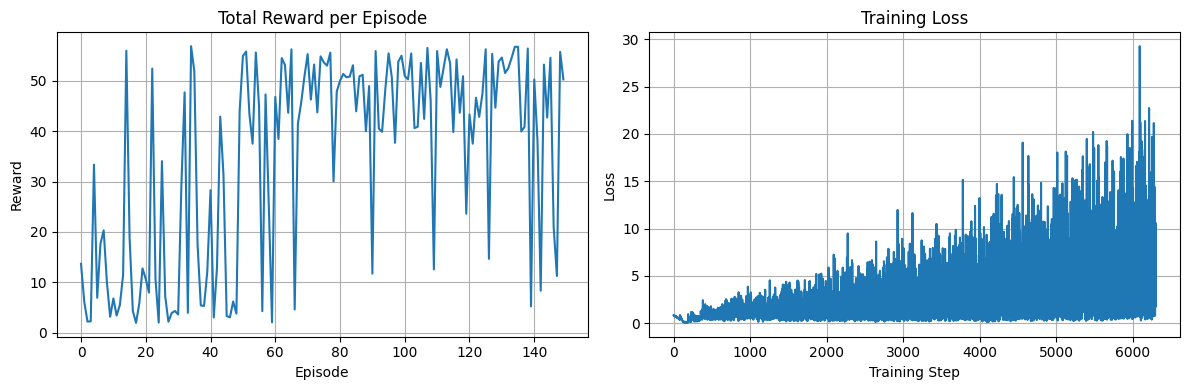

In [11]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(returns)
plt.title("Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.grid(True)

plt.tight_layout()
plt.show()

### 9. Evaluate the trained agent


In [12]:
# Use a new environment for evaluation
eval_env = gym.make("highway-fast-v0", render_mode="human")
eval_env.unwrapped.configure(config)

state, _ = eval_env.reset()

for _ in range(400):
    with torch.no_grad():
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        action = policy_net(state_tensor).argmax().item()
    state, reward, done, truncated, _ = eval_env.step(action)
    eval_env.render()
    time.sleep(0.05)
    if done or truncated:
        break

eval_env.close()